# Import modules

In [1]:
# https://pygis.io/docs/e_interpolation.html?highlight=voronoi
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from shapely.geometry import box
from shapely.geometry import Polygon, Point


In [2]:
# root directory
wdir = os.getcwd()

In [3]:
ECMWF_dir = wdir + '/ECMWF'
SNIRH_dir = wdir + '/SNIRH'
CNN_dir = wdir + '/CNN'
IMAGES_dir = wdir + '/IMAGES'
SHP_dir = wdir + '/SHP'

# Load netCDF file

In [4]:
os.chdir(ECMWF_dir)

In [5]:
#Open the NetCDF

# https://pratiman-91.github.io/2020/08/01/NetCDF-to-GeoTIFF-using-Python.html

import xarray as xr
import rioxarray as rio


#Download the sample from https://www.unidata.ucar.edu/software/netcdf/examples/sresa1b_ncar_ccsm3-example.nc

ncfname = '1985_T2m_tcc_tp.nc'
ncfile = xr.open_dataset(ncfname)

# Inspect the file
ncfile

<xarray.Dataset>
Dimensions:    (longitude: 42, latitude: 30, time: 8760)
Coordinates:
  * longitude  (longitude) float32 -9.07 -9.02 -8.97 -8.92 ... -7.12 -7.07 -7.02
  * latitude   (latitude) float32 41.0 40.95 40.9 40.85 ... 39.65 39.6 39.55
  * time       (time) datetime64[ns] 1985-01-01 ... 1985-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-30 12:59:39 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
#(Optional) convert longitude from (0-360) to (-180 to 180) (if required)
ncfile.coords['longitude'] = (ncfile.coords['longitude'] + 180) % 360 - 180
ncfile = ncfile.sortby(ncfile.longitude)

#Define lat/long 
ncfile = ncfile.rio.set_spatial_dims('longitude', 'latitude')

ncfile

<xarray.Dataset>
Dimensions:    (longitude: 42, latitude: 30, time: 8760)
Coordinates:
  * longitude  (longitude) float32 -9.07 -9.02 -8.97 -8.92 ... -7.12 -7.07 -7.02
  * latitude   (latitude) float32 41.0 40.95 40.9 40.85 ... 39.65 39.6 39.55
  * time       (time) datetime64[ns] 1985-01-01 ... 1985-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-30 12:59:39 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [7]:
#Extract the variable (daily total precipitation)
tp_daily = ncfile['tp']

tp_daily

<xarray.DataArray 'tp' (time: 8760, latitude: 30, longitude: 42)>
[11037600 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -9.07 -9.02 -8.97 -8.92 ... -7.12 -7.07 -7.02
  * latitude   (latitude) float32 41.0 40.95 40.9 40.85 ... 39.65 39.6 39.55
  * time       (time) datetime64[ns] 1985-01-01 ... 1985-12-31T23:00:00
Attributes:
    units:      m
    long_name:  Total precipitation

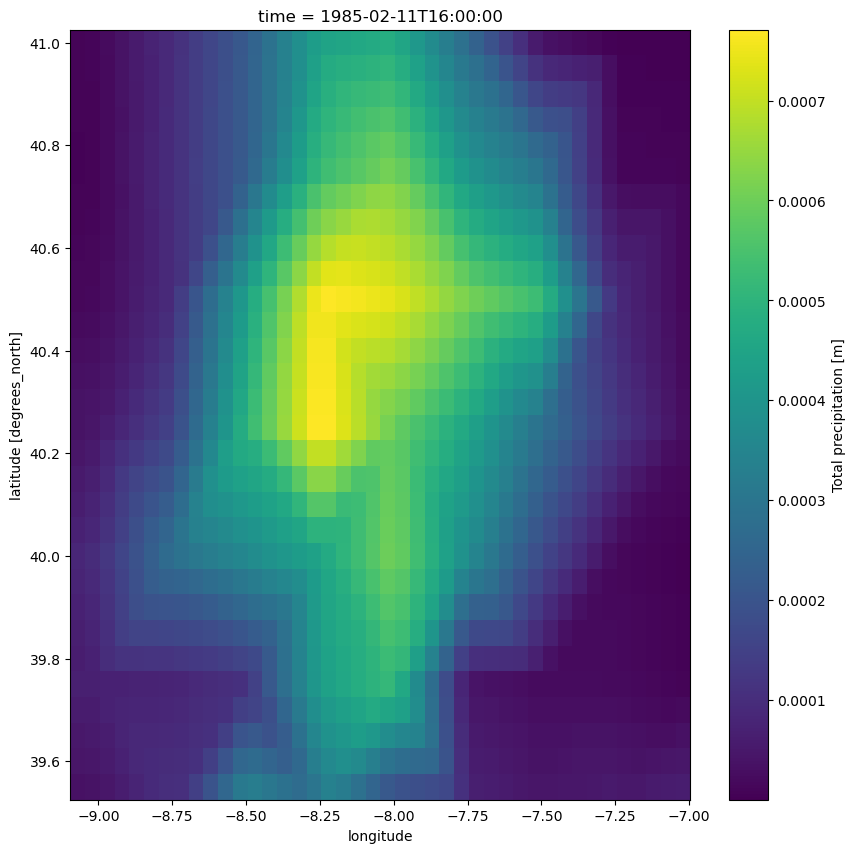

In [9]:
# Plot an example of the variable 


idx = 1000

# https://docs.xarray.dev/en/stable/user-guide/plotting.html
tp_daily[idx].plot(figsize = (10,10))

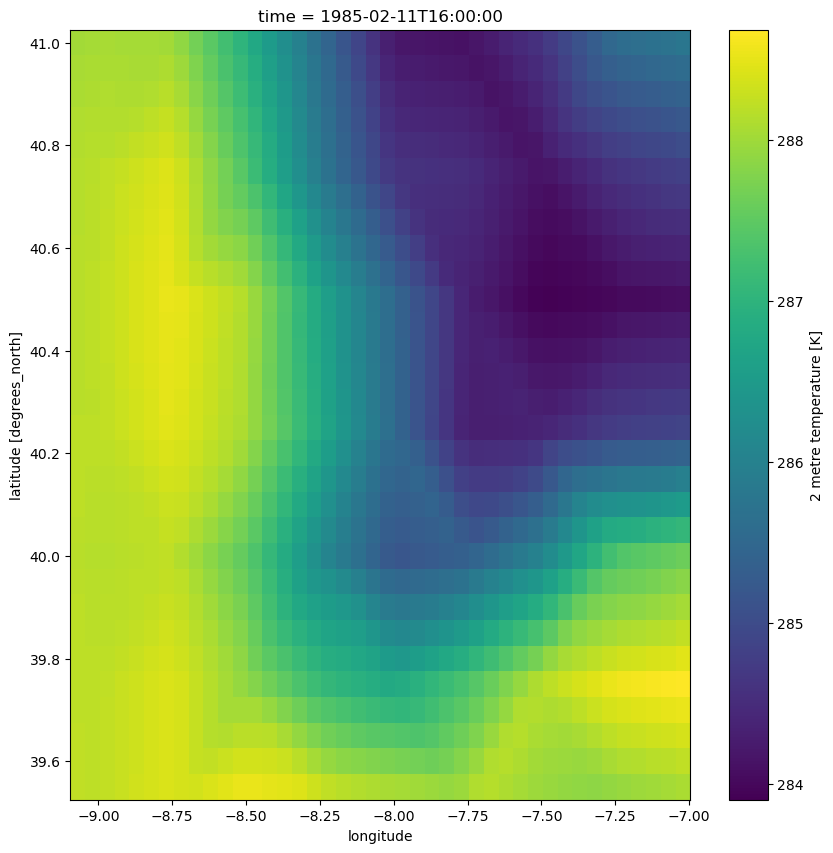

In [22]:
# https://docs.xarray.dev/en/stable/user-guide/plotting.html
ncfile['t2m'][idx].plot(figsize = (10,10))

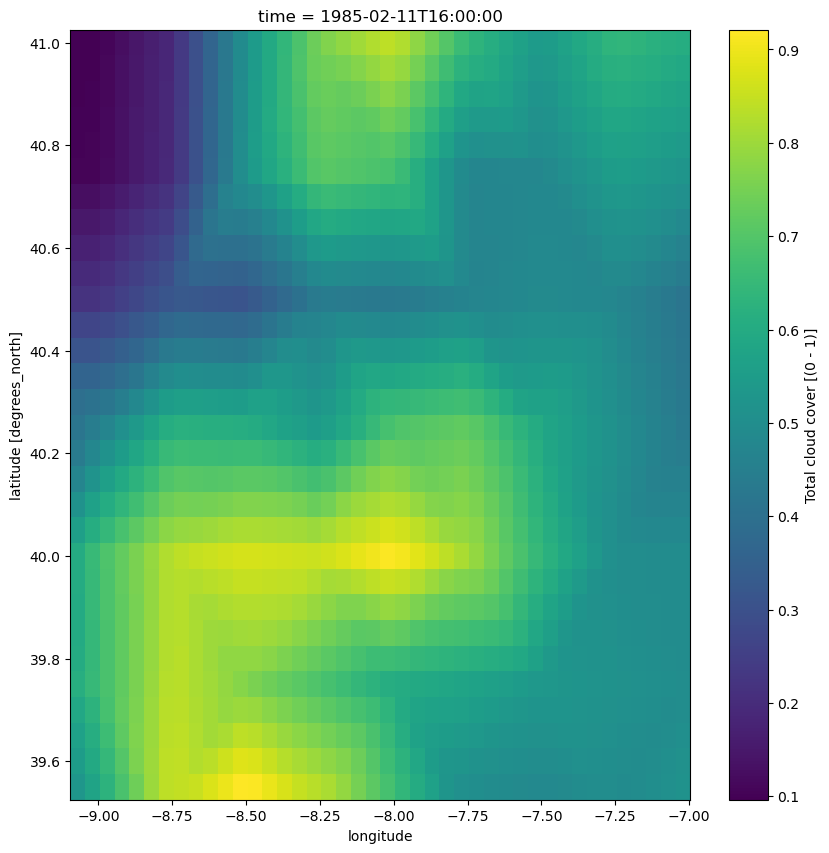

In [23]:
# https://docs.xarray.dev/en/stable/user-guide/plotting.html
ncfile['tcc'][idx].plot(figsize = (10,10))

In [10]:
# convert to dataframe

# https://stackoverflow.com/questions/65504116/how-to-convert-a-xarray-dataarray-to-a-geopandas-geodataframe
import geopandas as gpd
import xarray as xr


df_tp = tp_daily[idx].to_dataframe().reset_index()

In [11]:
# https://pyproj4.github.io/pyproj/stable/examples.html
from pyproj import CRS

crs = CRS.from_epsg(3763)

In [12]:
# Convert to geopandas df

# lat/lon coordinates 
lats = df_tp.latitude
lons = df_tp.longitude

# converts the xarray to dataframe and converts rainfall depth to mm
gdf_grid = gpd.GeoDataFrame(
    df_tp.tp * 1000, geometry = gpd.points_from_xy(lons, lats))

c:\ProgramData\Anaconda3\envs\rioxarray_env\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [13]:
gdf_grid.head()

,tp,geometry
0,0.009044,POINT (-9.07001 41.00000)
1,0.010713,POINT (-9.02000 41.00000)
2,0.021565,POINT (-8.97000 41.00000)
3,0.038538,POINT (-8.92000 41.00000)
4,0.055511,POINT (-8.87000 41.00000)


In [14]:
# x interval 

delta_lon = lons[1] - lons[0]
delta_lon

0.0500030517578125

In [15]:

# Buffer the points using a square cap style
# Note cap_style: round = 1, flat = 2, square = 3
buffer = gdf_grid.buffer(delta_lon / 2, cap_style = 3)

In [16]:
# https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html
outCRS = 3763                       # PT coordinates
intCRS = 4326                       # lon/lat coordinates

In [17]:
# sets the current crs of the grid dataframe, which is in lat/lon system
buffer.crs = intCRS

buffer.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
# converts to PT coordinates
buffer = buffer.to_crs(outCRS)
buffer.crs

<Derived Projected CRS: EPSG:3763>
Name: ETRS89 / Portugal TM06
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Portugal - mainland - onshore.
- bounds: (-9.56, 36.95, -6.19, 42.16)
Coordinate Operation:
- name: Portugual TM06
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [19]:
gdf_grid['grid'] = buffer

# Plot the river basin with the image grid

In [20]:
# path for shapefiles folder
SHP_dir = wdir + '/SHP'

# change directory
os.chdir(SHP_dir)


#loads the river basin limitsn stations and polygons
gdf_Mondego_tp = gpd.read_file('gdf_Mondego_tp.shp')
gdf_Mondego_stations = gpd.read_file('gdf_Mondego_stations.shp')
gdf_Mondego_rb = gpd.read_file('gdf_Mondego_rb.shp')

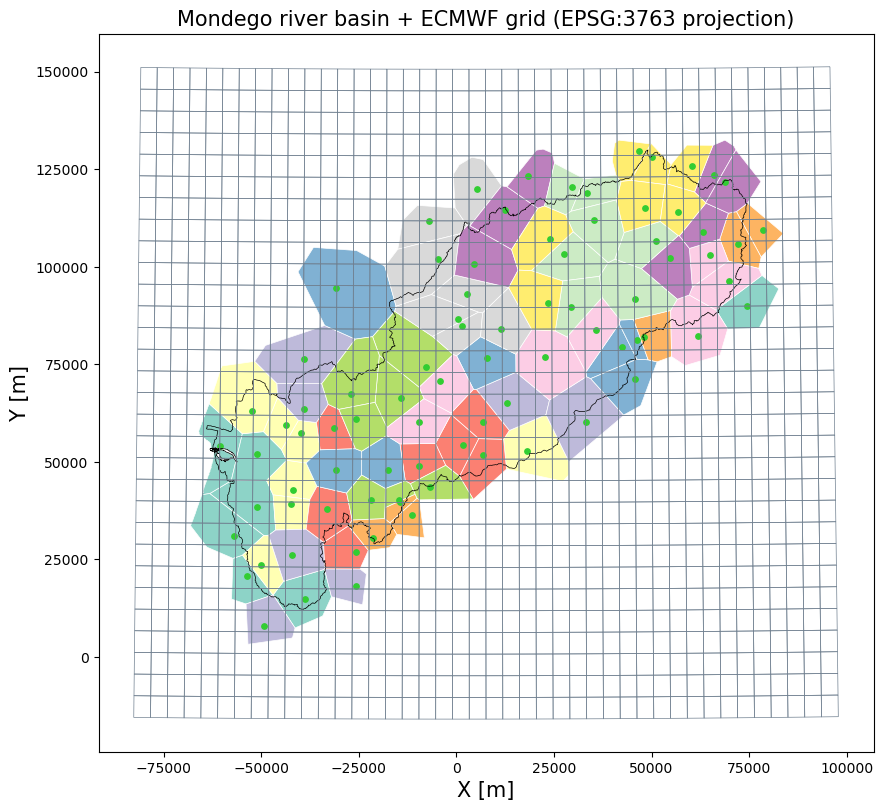

In [21]:
# https://gis.stackexchange.com/questions/314949/creating-square-buffers-around-points-using-shapely
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt


# change directory
os.chdir(ECMWF_dir)


# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
# plt.style.use('bmh')

# Plot data
# basins_dissolved.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
gdf_Mondego_tp.plot(ax = ax, cmap = 'Set3', edgecolor = 'white', linewidth = 0.5)
gdf_Mondego_stations.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 15)
gdf_Mondego_rb.plot(ax = ax, color = 'none', edgecolor = 'black', linewidth = 0.5)
gdf_grid['grid'].boundary.plot(ax=ax, color = 'slategrey', linewidth = 0.5)

# Iterate through each rainfall train point to add a label with its value to the plot
# for index, row in gdf_Mondego_stations.iterrows():
#     ax.annotate(row.codigo, (row.geometry.x, row.geometry.y), fontsize=5)

# Set title
ax.set_title(f'Mondego river basin + ECMWF grid (EPSG:{outCRS} projection)', fontdict = {'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel(f'X [m]', fontdict = {'fontsize': '15', 'fontweight' : '3'})
ax.set_ylabel(f'Y [m]', fontdict = {'fontsize': '15', 'fontweight' : '3'})

plt.savefig('grid_overlaid.png')